# AI Voiceover with GPT4V - @martintmv

> Jupyter Notebook implementation of https://github.com/martintmv-git/gpt4v-streamlit-voiceover.

> Example of weather forecast voiceover with GPT4V.

## 1. Importing Libraries

In this step, I import the necessary Python libraries that will be used throughout the notebook. This includes libraries for displaying images and audio within the notebook, handling environmental variables, video processing, and making requests to API.

In [51]:
from IPython.display import display, Image, Audio
from dotenv import load_dotenv
import cv2
import base64
import time
import openai
import os
import requests

## 2. Extracting Frames from the Video
Here I utilize `OpenCV` to capture frames from the video file. `OpenCV` reads the video and extracts each frame which we encode into base64 format. This format is suitable for sending over web requests when calling API services that process images. We store these `base64-encoded` frames in a list for further processing.


In [34]:
video = cv2.VideoCapture("data/weather_map.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

351 frames read.


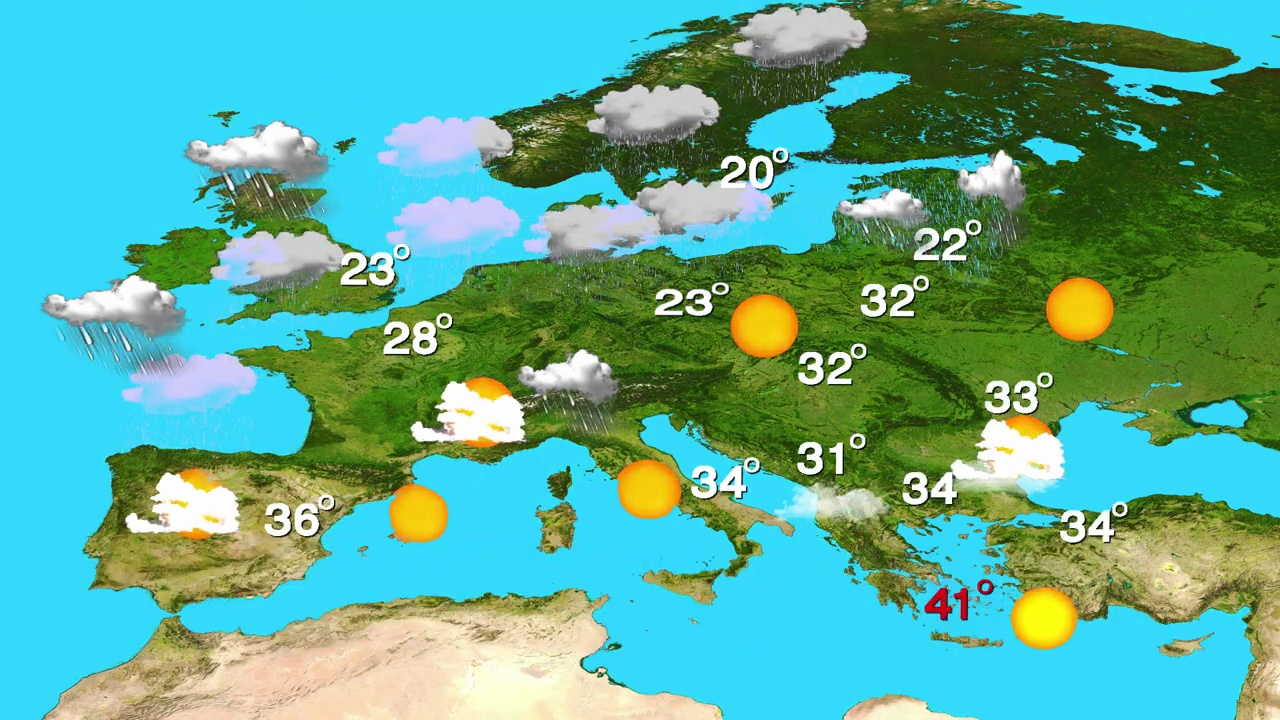

In [35]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

## 3. Generating the Voiceover Script with GPT-4V
Here I create a message prompt that describes the task for the model. The message includes instructions for the `llm` on the style and content of the voiceover script. We then send this prompt, along with selected frames from the video, to `OpenAI's GPT-4V model`. The model generates a script based on our prompt and the context provided by the video frames.

> You can play around and adjust the prompt to see how it affects the generated script. 

> You can also adjust the frames that are sent to the model and find your own combination of frames that work best for your video.

In [46]:
load_dotenv()

API_KEY = os.getenv('API_KEY')

PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a weather forecast video. Create a short voiceover script in the style of a narrator of a European weather map who is enthusiastic and engaging, mention activities to do in the sunny weather. Describe the weather conditions with excitement and energy, making it captivating for the viewers. Use no more than 100 words.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::45]), # every 45th frame
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "api_key": API_KEY,
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 500,
}

result = openai.ChatCompletion.create(**params)
print(result.choices[0].message.content)

Good evening, Europe! Are you ready for a sensational sunny splendor? 🌞 In the South, the sun reigns supreme with glorious highs of 34°C—perfect for an adventurous hike or a lazy beach day! Central regions, grab your sunglasses, as cheerful clouds make for splendid picnicking weather! 🥪🌳 Meanwhile, the North is getting a refreshing sprinkle, so why not dance in the rain or enjoy a cozy café afternoon? 💃☕ Everywhere you go, there are smiles and sunshine, and the great outdoors beckons! Embrace the warmth, Europe, and make the most of this absolutely stunning weather! Stay sun-kissed and sensational! ☀️🌷


## 4. Converting Text to Speech
After receiving the generated script from GPT-4, we use a `Text-to-Speech(TTS)` service to convert the text into an audio file. This involves sending a POST request to the TTS service's API, with the script as input, and specifying the desired voice model. The service returns an audio stream which we save as an MP3 file.

OpenAI's TTS is great and really easy to implement, but if you want to use better and more customisable TTS, I recommend using [ElevenLabs](https://elevenlabs.io/docs/introduction), or you can also use [Google Cloud Text-to-Speech](https://cloud.google.com/text-to-speech) which offers 1 million characters per month for free.

In [47]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {API_KEY}",
    },
    json={
        "model": "tts-1-hd-1106",
        "input": result.choices[0].message.content,
        "voice": "fable",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)

## 5. Saving and Playing the Audio
The MP3 audio stream is written to a local path file on the disk in `/data`.

In [55]:
with open('data/output.mp3', 'wb') as file:
    file.write(audio)

print("The MP3 file has been saved locally as 'data/output.mp3'.")

The MP3 file has been saved locally as 'data/output.mp3'.
